## Ricker Model estimation with approximated likelihood ratios

Juan Pavez, March 2016.

In this notebook we study the usability of the method [Approximating Likelihood Ratios with Calibrated Discriminative Classifiers](http://inspirehep.net/record/1377273) for times series parameter estimation.

For this, the Ricker classical populatiol model is used (this model shows near-chaotic dynamics). The ricker model is defined as:
$$ X_{t+1} = rX_t\exp(-X_t + e_t) $$
where $e_t$ is independent with $Normal(0,\sigma^2)$ distribution.
The process is not observed directly, instead samples with poisson distribution are observed.
$$ Y_t = Poisson(\phi X_t) $$
The Ricker model is an example of state space models.
We first only consider the time serie $X$ in order to study parameter estimation using approximated likelihood ratios on time series.
Here, the distribution is only conditioned by the previous value $p(x_t|x_{t-1})$. 
The joint probability distribution is then 
$$p_{x_t,...x_1}(x_t,...x_1;\theta) = \prod_{t=2}^T{p_{x_t|x_{t-1}}(x_t|x_{t-1};\theta)} * p_{x_1}(x_1;\theta)$$

or if we keep $x_1$ deterministic, the conditional likelihood can be used instead 
$$\prod_{t=2}^T{p_{x_t|x_{t-1}}(x_t|x_{t-1};\theta)}$$ . 

A recurrent neural network trained on the sequences $X' = [{x_t,x_{t-1}}]$ will approximate the posterior probability $p(y_t|x_t,x_{t-1})$ which is monotonic to the ratio $p(x_t|x_{t-1};\theta_0)/ p(x_t|x_{t-1};\theta_1)$

Then to compute the likelihood ratio :
$$\frac{L(\theta_0)}{L(\theta_1)} = \prod_{t=1}^T \frac{p_{x_t|x_{t-1}}(x_t|x_{t-1};\theta_0)}{p_{x_t|x_{t-1}}(x_t|x_{t-1};\theta_1)}$$
 we can replace the ratios $p(x_t|x_{t-1};\theta_0)/ p(x_t|x_{t-1};\theta_1)$  by the distribution of the score of the trained RNN $p(s([x_t,x_{t-1}])|\theta_0)/ p(s([x_t,x_{t-1}])|\theta_1)$.
 
Then, we can use maximum likelihood on the approximated likelihood ratios (keeping the ratio fixed) in order to estimate the parameters of the time series model.

We start by estimating the parameter $r$ from $\theta = (r,\sigma^2,\phi)$.



In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import theano
matplotlib.style.use('ggplot')

import os, sys, inspect
cmd_folder = os.path.realpath(os.path.abspath(os.path.split(inspect.getfile( inspect.currentframe() ))[0]))
if cmd_folder not in sys.path:
    sys.path.insert(0, cmd_folder + '/carl')

np.random.seed(1234)

In [2]:
def logit(x):
    return np.log(x) - np.log(1-p)
def logistic(x):
    return 1. / (1. + np.exp(-x)) 


In [3]:
r_value = 3.8
sigma_2_value = 0.3**2
phi_value = 5.
r_bkg = 5.
phi_bkg = 8.

shared_r = theano.shared(r_value, name="r")
shared_sigma_2 = theano.shared(sigma_2_value,name="sigma_2")
shared_phi = theano.shared(phi_value, name="phi")

class Ricker:
    def __init__(self,r,sigma_2,phi):
        self.r = r
        self.sigma_2 = sigma_2
        self.phi = phi
    
    def sample(self,r=0.5, sigma_2=1., phi=0.1, start=0.1,n_timesteps=1000, rng=None):
        noise = rng.normal(0.,sigma_2, n_timesteps)
        time_serie = np.zeros(n_timesteps,dtype=np.float64)
        time_serie[0] = np.abs(noise[0])
        r_e = np.exp(r)
        for i in range(1,n_timesteps):
            time_serie[i] = (r_e*time_serie[i-1]*np.exp(-time_serie[i-1] + noise[i]))

        sampled = np.zeros(n_timesteps)
        sampled = np.array([rng.poisson(phi*time_serie[i]) for i in range(0,n_timesteps,1)])
        
        return_serie = np.log(time_serie[1:]/(time_serie[:-1]))
        
        return time_serie.reshape(time_serie.shape[0],1), sampled.reshape(sampled.shape[0],1),return_serie.reshape(return_serie.shape[0],1)
    def rvs(self,n_samples, random_state=1234):
        rng = np.random.RandomState(random_state) if \
                isinstance(random_state,int) else random_state
        return self.sample(r=self.r.eval(),sigma_2=self.sigma_2.eval(),phi=self.phi.eval(),
                     n_timesteps=n_samples,rng=rng)[1]
                
    
#serie1,sampled1 = ricker(r=np.exp(3.8),sigma_2=0.3**2,phi=10.,n_timesteps=n_samples,start=0.5)
#serie2,sampled2 = ricker(r=np.exp(4.5), sigma_2=0.3**2,phi=10.,n_timesteps=n_samples,start=0.5)

#X_true,X_true_obs = ricker(r=np.exp(3.8),sigma_2=0.3**2,phi=10.,n_timesteps=1500,start=0.5)


In [4]:
n_samples = 10000 # train
test_samples = 1500 # test
hist_samples = 10000 # histograms
n_bins = 15 # histogram construction
max_len = 4
n_sampled = 100
# best results 10000,1500,10000,15,4,100

In [5]:
p0 = Ricker(r=shared_r,sigma_2=shared_sigma_2,phi=shared_phi)
#p1 = Ricker(r=np.exp(4.5), sigma_2=0.3**2,phi=10.)
p1 = Ricker(r = theano.shared(r_bkg, name="r_1"),
            sigma_2 = theano.shared(0.3**2,name="sigma_2_1"),
            phi = theano.shared(phi_bkg, name="phi_1")
            )
rng = np.random.RandomState(1234)

#X_true = np.array([p0.rvs(max_len, random_state = i) for i in range(test_samples)])
#X_true = p0.rvs(1000000,random_state=rng)
#m_true = X_true.mean()
#s_true = X_true.std()
X_true = p0.rvs(test_samples, random_state=rng)
#print X_true

0 89
0 516


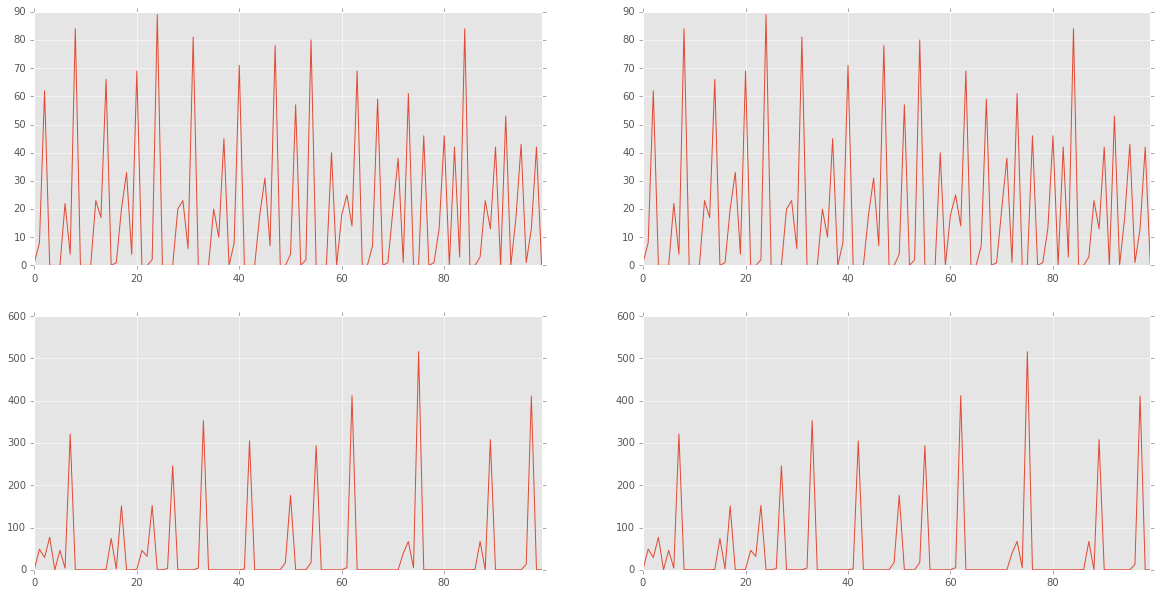

In [6]:
serie1 = p0.rvs(100).ravel()
serie2 = p1.rvs(100).ravel()
#serie1 = (serie1 - serie1.mean()) / serie1.std()
#serie2 = (serie2 - serie2.mean()) / serie2.std()
plt.figure(figsize=(20,10))
plt.subplot(221)
ts = pd.Series(serie1)
ts[0:100].plot()
plt.subplot(222)
ts = pd.Series(serie1)
ts.plot()
plt.subplot(223)
ts = pd.Series(serie2)
ts[0:100].plot()
plt.subplot(224)
ts = pd.Series(serie2)
ts.plot()
print serie1.min(),serie1.max()
print serie2.min(),serie2.max()

In [7]:
#from carl.learning import make_parameterized_classification

#X, y = make_parameterized_classification(
#    p0, p1,
#    n_samples, 
#    [(shared_r, np.linspace(3.3,4.5, num=15))],
#    random_state=1234)


In [8]:
from carl.learning import ParameterStacker

from itertools import product
def make_parametrized_classification_std(p0, p1, n_samples, params, rng):
    if not isinstance(params[0], tuple):
        X0 = p0.rvs(n_samples // 2, random_state=rng)
        X1 = p1.rvs(n_samples - (n_samples // 2), random_state=rng)
        X = ParameterStacker(params).transform(np.vstack((X0, X1)))
        y = np.zeros(n_samples)
        y[len(X0):] = 1

        return X, y

    elif isinstance(params[0], tuple):
        combinations = list(product(*[values for _, values in params]))

        all_X = []
        all_y = []

        for c in combinations:
            for i, v in enumerate(c):
                params[i][0].set_value(v)

            X, y = make_parametrized_classification_std(
                p0, p1,
                n_samples // len(combinations),
                [p for p, _ in params], rng=rng)

            all_X.append(X)
            all_y.append(y)

        X = np.vstack(all_X)
        y = np.concatenate(all_y)

        return X, y

    else:
        raise ValueError

In [9]:
Xs, ys = [],[]
for n in range(n_sampled):
    X, y = make_parametrized_classification_std(
        p0, p1,
        n_samples, 
        [(shared_r, np.linspace(3.3,4.5, num=10)),
        (shared_phi, np.linspace(3.5,7.5,num=10))],
        rng=n)
    Xs.append(X)
    ys.append(y)

In [10]:
print(Xs[0])

[[ 0.   3.3  3.5]
 [ 8.   3.3  3.5]
 [ 6.   3.3  3.5]
 ..., 
 [ 0.   4.5  7.5]
 [ 0.   4.5  7.5]
 [ 0.   4.5  7.5]]


In [11]:
import pdb
X_series, y_series = [],[]

for n in range(n_sampled):
    X0_serie = []
    y0_serie = []
    X1_serie = []
    y1_serie = []

    X0 = Xs[n][ys[n] == 0]
    X1 = Xs[n][ys[n] == 1]
    for i in xrange(X0.shape[0]-max_len+1):
        # ensure that is from same time serie
        if X0[i][-1] == X0[i+max_len-1][-1] and X0[i][-2] == X0[i+max_len-1][-2]:
            X0_serie.append(X0[i:i+max_len])
        if X1[i][-1] == X1[i+max_len-1][-1] and X1[i][-2] == X1[i+max_len-1][-2]:
            X1_serie.append(X1[i:i+max_len])
    X0_serie = np.array(X0_serie)
    X1_serie = np.array(X1_serie)

    X0_serie = X0_serie[np.random.choice(X0_serie.shape[0],X0_serie.shape[0],replace=False)]
    X1_serie = X1_serie[np.random.choice(X1_serie.shape[0],X1_serie.shape[0],replace=False)]

    X_serie = np.vstack((
         X0_serie,
         X1_serie))
    y_serie = np.zeros(X0_serie.shape[0]*2,dtype=np.int)
    y_serie[X0_serie.shape[0]:] = 1
    
    X_series.append(X_serie)
    y_series.append(y_serie)



In [12]:
print(X0.shape)

(5000, 3)


In [13]:
X_serie = X_series[0]
y_serie = y_series[0]
for k in range(1,len(X_series)):
    X_serie = np.vstack((X_serie,X_series[k]))
    y_serie = np.hstack((y_serie,y_series[k]))

In [14]:
print(X_serie.shape)

(940000, 4, 3)


In [15]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, GRU, LSTM, Dropout
from carl.learning import as_classifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD


def make_model():
    model = Sequential()
    model.add(SimpleRNN(15,input_shape=(max_len,X_serie.shape[2])))
    model.add(Dropout(0.3))
    model.add(Dense(5,activation='tanh'))
    model.add(Dropout(0.3))
    model.add(Dense(1,activation='sigmoid'))
    #sgd = SGD(lr=0.01, clipnorm=40.)
    model.compile(loss="binary_crossentropy", optimizer='adam')
    return model


clf = KerasClassifier(make_model, nb_epoch=10, verbose=2)
#clf = make_pipeline(StandardScaler(),as_classifier(clf))

clf.fit(X=X_serie, y=y_serie)
#clf.fit(X=X_serie, y=y_serie,nb_epoch=3,batch_size=32,verbose=2)

Epoch 1/10
25s - loss: 0.2682
Epoch 2/10
25s - loss: 0.2199
Epoch 3/10
25s - loss: 0.2153
Epoch 4/10
25s - loss: 0.2124
Epoch 5/10
25s - loss: 0.2107
Epoch 6/10
25s - loss: 0.2090
Epoch 7/10
25s - loss: 0.2077
Epoch 8/10
26s - loss: 0.2067
Epoch 9/10
25s - loss: 0.2057
Epoch 10/10
24s - loss: 0.2053


Using Theano backend.


In [16]:
print clf.predict_proba(X_serie)

[[  9.98648763e-01   1.35124754e-03]
 [  9.95657206e-01   4.34280653e-03]
 [  9.98732150e-01   1.26784982e-03]
 ..., 
 [  9.47588682e-03   9.90524113e-01]
 [  1.39629841e-03   9.98603702e-01]
 [  5.74231148e-04   9.99425769e-01]]


In [17]:
from carl.ratios import ClassifierRatio
from carl.learning import CalibratedClassifierCV
from carl.learning import as_classifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

cc_direct = ClassifierRatio(
    base_estimator=CalibratedClassifierCV(clf, bins=10, cv='prefit', 
                                         method='histogram'), 
    random_state=0)
cc_direct.fit(X=X_serie,y=y_serie)

ClassifierRatio(base_estimator=CalibratedClassifierCV(base_estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0xfbe8d10>,
            bins=10, cv='prefit', method='histogram'),
        random_state=0)

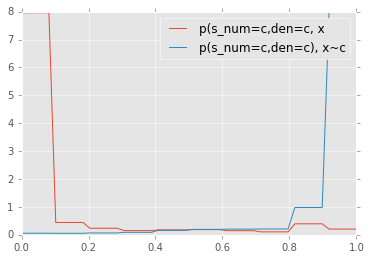

In [18]:
reals2 = np.linspace(0, 1)

cal_num, cal_den = cc_direct.classifier_.calibrators_[0].calibrators
plt.plot(reals2, cal_num.pdf(reals2.reshape(-1, 1)), 
         label="p(s_num=c,den=c, x")
plt.plot(reals2, cal_den.pdf(reals2.reshape(-1, 1)), 
        label="p(s_num=c,den=c), x~c")
plt.legend()
plt.show()


In [82]:

from carl.learning import CalibratedClassifierCV
from carl.ratios import ClassifierRatio
import pdb

def vectorize(func):
    def wrapper(X):
        v = np.zeros(len(X))
        
        for i, x_i in enumerate(X):
            v[i] = func(x_i)
            
        return v.reshape(-1, 1)
    
    return wrapper
def objective(theta, random_state=0, X_true=None):    
    #print(theta)
    shared_r.set_value(theta[0])
    shared_phi.set_value(theta[1])
    serie1 = p0.rvs(hist_samples)
    #serie1 = (serie1 - serie1.mean()) / serie1.std()
    # Set parameter values   
    X0 = np.zeros((serie1.shape[0],serie1.shape[1]+2))
    X0[:,:-2] = serie1
    X0[:,-2] = theta[0]
    X0[:,-1] = theta[1]
    
    # Fit ratio
    ratio = ClassifierRatio(CalibratedClassifierCV(
        base_estimator=clf, 
        cv="prefit",  # keep the pre-trained classifier
        method="histogram", bins=20))

    serie2 = p1.rvs(hist_samples,random_state=random_state)
    #serie2 = (serie2 - m1) / s1
    X1 = np.zeros((serie2.shape[0],serie2.shape[1]+2))
    X1[:,:-2] = serie2
    X1[:,-2] = r_bkg
    X1[:,-1] = phi_bkg

    X0_serie = []
    X1_serie = []

    for i in xrange(serie1.shape[0]-max_len):
        X0_serie.append(X0[i:i+max_len])
        X1_serie.append(X1[i:i+max_len])
    X0_serie = np.array(X0_serie)
    X1_serie = np.array(X1_serie)
    X0_serie = X0_serie[np.random.choice(X0_serie.shape[0],X0_serie.shape[0],replace=False)]
    X1_serie = X1_serie[np.random.choice(X1_serie.shape[0],X1_serie.shape[0],replace=False)]

    X_serie = np.vstack((
         X0_serie,
         X1_serie))
    y_serie = np.zeros(X0_serie.shape[0]*2,dtype=np.int)
    y_serie[X0_serie.shape[0]:] = 1
    
    ratio.fit(X_serie, y_serie)
    
    # Evaluate log-likelihood ratio
    X_true_ = np.zeros((X_true.shape[0],X_true.shape[1]+2))
    X_true_[:,:-2] = X_true
    X_true_[:,-2] = theta[0]
    X_true_[:,-1] = theta[1]
    
    X_true_serie = []
    for i in xrange(X_true_.shape[0]-max_len):
        X_true_serie.append(X_true_[i:i+max_len])
    X_true_serie = np.array(X_true_serie)
    X_true_serie = X_true_serie[np.random.choice(X_true_serie.shape[0],X_true_serie.shape[0],
                                                replace=False)]
    
    r = ratio.predict(X_true_serie, log=True)
    zeros = r[np.isinf(r)].shape
    #print r[np.isfinite(r)].shape
    #value = -np.mean(r[np.isfinite(r)])  # optimization is more stable using mean
                                         # this will need to be rescaled by len(X_true)
    
    #r[np.isinf(r)] = 0.
    value = -np.mean(r[np.isfinite(r)])
    #print zeros
    #print value

    return value, zeros[0]


In [83]:

# Contours of the approximated LR
shared_r.set_value(r_value)
shared_phi.set_value(phi_value)

bounds = [(3.4,4.),
          (3.5,7.)]

As = np.linspace(bounds[0][0],bounds[0][1], 10)
Bs = np.linspace(bounds[1][0],bounds[1][1], 10)
AA, BB = np.meshgrid(As, Bs)
X = np.hstack((AA.reshape(-1, 1),
               BB.reshape(-1, 1)))

In [84]:
approx_contours = np.zeros(len(X))
zeros = np.zeros(len(X))
X_true = p0.rvs(500, random_state=np.random.randint(0,5000))

i = 0
for a in As:    
    for b in Bs:
        approx_contours[i],zeros[i] = objective([a, b],X_true=X_true) 
        i += 1
        
approx_contours = 2. * (approx_contours - approx_contours.min()) * len(X_true)

In [85]:
approx_contours

array([ 1957.56740089,  1554.16343942,  1298.30148434,  1105.41893022,
         909.94664543,   748.42422248,   653.98919207,   656.35827514,
         566.68189108,   503.3737055 ,  1637.68354953,  1257.8679022 ,
         975.85379717,   837.63848105,   673.1811074 ,   582.23319975,
         512.19080118,   417.6839628 ,   424.63669439,   430.72933819,
        1254.73507247,   972.12515059,   767.25065705,   670.34623874,
         509.71879786,   418.62940637,   374.42700621,   344.24829044,
         307.70221865,   271.66340624,   974.59561551,   739.16699892,
         570.32615071,   432.53484079,   348.4001161 ,   296.01868843,
         250.80595775,   223.85668629,   194.45427711,   184.13225167,
         700.09841817,   520.45408424,   353.48930335,   227.28650618,
         144.84406469,   130.23317328,   144.183605  ,   131.96683725,
         142.89397805,   159.1545671 ,   504.34500498,   359.48607528,
         257.9206085 ,   128.48662843,    77.72427072,    48.49003302,
      

(3.7333333333333334, 6.2222222222222223) 

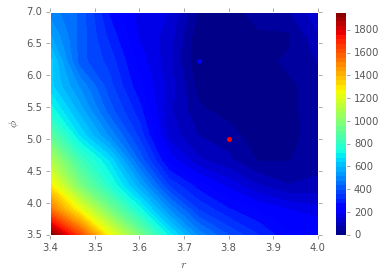

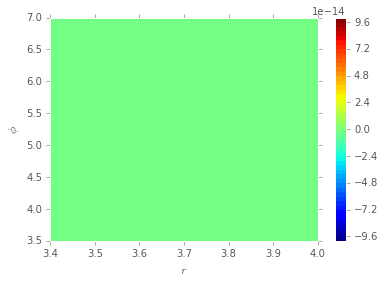

In [86]:
from scipy.stats import chi2
import pdb

min_value = np.unravel_index(approx_contours.argmin(),
            (10,10))
min_position = (As[min_value[0]],Bs[min_value[1]])
print '{0} '.format(min_position),
#plt.contour(As, Bs, approx_contours.reshape(AA.shape).T, 
#            levels=[chi2.ppf(0.683, df=2), 
#                    chi2.ppf(0.9545, df=2),
#                    chi2.ppf(0.9973, df=2)], colors=["w"])
plt.contourf(As, Bs, approx_contours.reshape(AA.shape).T, 50)
plt.colorbar()

plt.plot([r_value], [phi_value], "r.", markersize=8)
plt.plot([r_value], [phi_value], "r.", markersize=8)
plt.plot([min_position[0]], [min_position[1]], "b.", markersize=8)


plt.axis((bounds[0][0],bounds[0][1],bounds[1][0],bounds[1][1]))
plt.xlabel(r"$ r$")
plt.ylabel(r"$\phi$")

#plt.savefig("fig4c.pdf")
plt.show()

plt.contourf(As, Bs, zeros.reshape(AA.shape).T, 50)
plt.colorbar()

plt.axis((bounds[0][0],bounds[0][1],bounds[1][0],bounds[1][1]))
plt.xlabel(r"$ r$")
plt.ylabel(r"$\phi$")
plt.show()

In [81]:
n_hist = 50
hist_values = np.zeros((n_hist,2))
approx_contours = np.zeros(len(X))


for h in range(n_hist):
    shared_r.set_value(r_value)
    shared_phi.set_value(phi_value)
    random_state = np.random.randint(0,5000)
    print(random_state)
    X_true = p0.rvs(500,random_state=random_state)
    zeroes = np.zeros(len(X))
    i = 0
    for a in As:    
        for b in Bs:
            approx_contours[i],zeros[i] = objective([a, b],X_true=X_true) 
            i += 1
        
    approx_contours = 2. * (approx_contours - approx_contours.min()) * len(X_true)
    min_value = np.unravel_index(approx_contours.argmin(),
                (10,10))
    min_position = (As[min_value[0]],Bs[min_value[1]])
    print '{0} '.format(min_position),
    hist_values[h] = min_value
#approx_contours = 2. * (approx_contours - approx_contours.min()) * len(X_true)


2096
(3.8666666666666667, 5.8333333333333339)  2516
(3.8666666666666667, 5.8333333333333339)  2460
(3.7999999999999998, 6.6111111111111107)  79
(3.7999999999999998, 6.6111111111111107)  3643
(3.7999999999999998, 6.2222222222222223)  3901


KeyboardInterrupt: 

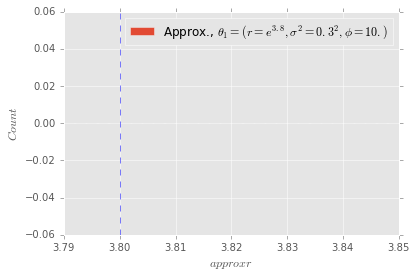

In [25]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
#print gp_ratios

ax.hist(hist_values, range=(3.79,3.85), 
        label=r"Approx., $\theta_1=(r=e^{3.8},\sigma^2=0.3^2,\phi=10.)$", bins=30)
ax.set_xlabel(r"$approx r$")
ax.set_ylabel(r"$Count$")
#plt.legend()

ax.legend()
#ax.set_ylim(-2., 14)
#ax.set_xlim(bounds[0][0],bounds[0][1])
ax.axvline(x=r_value,linestyle='dashed',alpha=0.5)
plt.savefig('likelihood_comp.pdf')
plt.show()

TO-DO:
* 2D parameter estimation.
* Parameter estimation on $Y_t$ (here the method must be adapted for state space models).

* Check with other parameters
* Try with an easier model e.g simple autoregresive model

In [26]:
As[min_value[0]],Bs[min_value[1]]


(3.8666666666666667, 5.4444444444444446)